## 4. Time Series.

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 18.2 MB/s eta 0:00:00


### For the time series model, several options were considered, such as training ARIMA or PROPHET models, but in the end we saw that the best way to get better predictions was to use an XGBOOST model.

### In addition, the model was trained in different ways:
 - We initially opted for a daily training approach, which was much slower and required a lot of extra RAM and storage resources. This first approach resulted in less accurate predictions at the weekly level, which was not what we were interested in for our stocks. However, it was still an interesting approach for some specific products.

 - Secondly, and finally, an approach of grouping product sales by week was adopted in order to optimise resources and achieve more realistic forecasts.

### 4.1 Data Preparation.

#### We start by resampling the dataframe by weeks, in the sell_price column we will keep the last recent price of each product, it will be up to the sales team to change those prices.

In [ ]:
df_to_resample = df.set_index('date')

In [ ]:
df_time_series_semanas = df_to_resample.groupby([pd.Grouper(freq='W'), 'id']).agg({
    'item': 'first',
    'category': 'first',
    'store_code': 'first',
    'region': 'first',
    'department': 'first',
    'n_sales': 'sum',
    'revenue': 'sum',
    'sell_price': 'first'
}).reset_index()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df_time_series_semanas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8285760 entries, 0 to 8285759
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   id          object        
 2   item        object        
 3   category    object        
 4   store_code  object        
 5   region      object        
 6   department  object        
 7   n_sales     int64         
 8   revenue     float64       
 9   sell_price  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 632.2+ MB


#### We create a very useful function that allows us to create 28 new days, or 4 weeks in this case, to make our predictions for the future. To do this, we will keep the latest prices for each product and also fill the sales columns with zeros.

In [ ]:
def multistep_forecast(df):
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

  indice_28 = sorted(list(df["date"].unique()))[-4:]

  df_28 = df[df['date'].isin(indice_28)]

  df_28['date'] = df_28['date'].astype(str)

  lista_fechas_originales = df_28['date'].unique().tolist()

  new_day = df['date'].max() + pd.to_timedelta(1, unit='w')

  nuevo_rango_fechas = pd.date_range(start=new_day, periods=28, freq='W')

  date_strings = nuevo_rango_fechas.strftime('%Y-%m-%d').tolist()

  for valor_a, valor_b in zip(lista_fechas_originales, date_strings): #obtenemos los valores en cada iteración
	  df_28['date'] = np.where(df_28['date'] == valor_a, valor_b, df_28['date'])

  df_28['date'] = pd.to_datetime(df_28['date'], format='%Y-%m-%d')

  df_28['n_sales'] = 0

  df_final_time_series_forecast = pd.concat([df, df_28], axis=0).reset_index(drop=True)

  return df_final_time_series_forecast

In [ ]:
df_time_series = multistep_forecast(df_time_series_semanas)

### 4.2 Data Preprocessing.

#### We make LabelEncoder of the categorical columns.

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

lista_label = ['item', 'region', 'department', 'category', 'store_code']

for i in lista_label:
  df_time_series[i] = lb.fit_transform(df_time_series[i])

### 4.3 Feature engineering.

#### We start by creating time-related features such as year, quarter or month.

In [ ]:
def columnas_tiempo(df):
  df['trimestre'] = df['date'].dt.quarter
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month

In [ ]:
columnas_tiempo(df_time_series)

In [ ]:
df_time_series.tail()

,date,id,item,category,store_code,region,department,n_sales,revenue,sell_price,trimestre,year,month
8406715,2016-05-22,SUPERMARKET_3_827_NYC_3,3023,2,5,1,6,0,45.60,1.20,2,2016,5
8406716,2016-05-22,SUPERMARKET_3_827_NYC_4,3023,2,6,1,6,0,26.40,1.20,2,2016,5
8406717,2016-05-22,SUPERMARKET_3_827_PHI_1,3023,2,7,2,6,0,18.00,1.20,2,2016,5
8406718,2016-05-22,SUPERMARKET_3_827_PHI_2,3023,2,8,2,6,0,14.40,1.20,2,2016,5
8406719,2016-05-22,SUPERMARKET_3_827_PHI_3,3023,2,9,2,6,0,0.00,1.20,2,2016,5


#### Through a function we create columns that allow us to improve our predictions, we will do it using the item, id, n_sales or revenue columns. Among the new columns we have:
  - Autoregressive measures: through a list of lags that are 4, 8 and 12 weeks we will create columns that help us to use information from the past to make our predictions.

  - Moving averages: using these lags we will carry out averages for the last 4 and 12 weeks.


In [ ]:
lista_lags = [4,8,12]
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):

    assert "date" in df_time_series.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    for i in lista_lags:

      gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(i)
      )

    for i in lista_lags:
      gb_df_[f"{new_name}_roll_4_{i}"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(i).rolling(window = 4).mean()
      )

      gb_df_[f"{new_name}_roll_12_{i}"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(i).rolling(window = 12).mean()
      )


    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

GB_LIST = ["item"]
TARGET_COLUMN = "n_sales"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df_time_series,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)


df_time_series = pd.merge(df_time_series, vars_ts_, on = ["date"] + GB_LIST, how = "left")

GB_LIST = ["id"]
TARGET_COLUMN = "revenue"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "sum"

vars_ts_ = build_ts_vars(
    df = df_time_series,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME

)

df_time_series = pd.merge(df_time_series, vars_ts_, on = ["date"] + GB_LIST, how = "left")

COLUMNS_TO_DROP = ['revenue']

df_time_series.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

Dropping columns that might cause target leakage item_n_sales_sum
Dropping columns that might cause target leakage id_revenue_sum


### 4.4 Training of our XGBOOST model.

Taking into account that we have already added the 4 weeks to predict within our dataframe, the partition for training will be as follows:

  - Train: all values minus the last 4 weeks of our original dataframe.
  - Validation: the values of the last 4 weeks of our original dataframe.
  - Test: the values of the 4 weeks to predict.

  ### After several tests, these parameters are chosen for the model.

In [ ]:
def train_test(df):
  df.set_index('id', inplace=True)

  train_index = sorted(list(df["date"].unique()))[:-8]
  valida_index = sorted(list(df["date"].unique()))[-8 :-4]
  test_index = sorted(list(df["date"].unique()))[-4:]
  X_train = df[df["date"].isin(train_index)].drop(['n_sales', "date"], axis=1)
  Y_train = df[df["date"].isin(train_index)]['n_sales']

  X_valida = df[df["date"].isin(valida_index)].drop(['n_sales', "date"], axis=1)
  Y_valida = df[df["date"].isin(valida_index)]['n_sales']

  X_test = df[df["date"].isin(test_index)].drop(['n_sales', "date"], axis=1)
  Y_test = df[df["date"].isin(test_index)]['n_sales']

  model = xgb.XGBRegressor(eval_metric = "rmse",
                            seed=175,
                            n_estimators=150,
                            early_stopping_rounds=15)

  model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_valida, Y_valida)], verbose=True)

  if "n_sales" in X_test.columns:
    X_test.drop("n_sales", axis = 1, inplace = True)

  Y_test_predict = model.predict(X_test)
  X_test["n_sales"] = Y_test_predict

  return Y_test_predict

In [ ]:
Y_test_predict = train_test(df_time_series)

[0]	validation_0-rmse:19.11988	validation_1-rmse:17.19692
[1]	validation_0-rmse:16.24824	validation_1-rmse:13.95943
[2]	validation_0-rmse:14.49899	validation_1-rmse:12.19564
[3]	validation_0-rmse:13.39723	validation_1-rmse:11.14197
[4]	validation_0-rmse:12.74583	validation_1-rmse:10.62435
[5]	validation_0-rmse:12.28256	validation_1-rmse:10.29646
[6]	validation_0-rmse:12.00647	validation_1-rmse:10.06806
[7]	validation_0-rmse:11.82504	validation_1-rmse:9.91766
[8]	validation_0-rmse:11.71142	validation_1-rmse:9.79262
[9]	validation_0-rmse:11.61246	validation_1-rmse:9.75124
[10]	validation_0-rmse:11.50752	validation_1-rmse:9.71637
[11]	validation_0-rmse:11.46782	validation_1-rmse:9.67816
[12]	validation_0-rmse:11.39940	validation_1-rmse:9.66497
[13]	validation_0-rmse:11.32517	validation_1-rmse:9.70401
[14]	validation_0-rmse:11.30833	validation_1-rmse:9.67649
[15]	validation_0-rmse:11.27023	validation_1-rmse:9.62937
[16]	validation_0-rmse:11.26403	validation_1-rmse:9.62849
[17]	validation_0

### 4.5 Creation of the Dataframe with the predictions.

In [ ]:
def dataframe_con_predicciones(df):
  train_index = sorted(list(df["date"].unique()))[:-8]
  valida_index = sorted(list(df["date"].unique()))[-8 :-4]
  test_index = sorted(list(df["date"].unique()))[-4:]
  df_para_cambiar_predict = df[df["date"].isin(test_index)]
  df_para_cambiar_predict['n_sales'] = Y_test_predict

  fecha_inicio = df['date'].max() - pd.to_timedelta(28, unit='d')
  fecha_fin = df['date'].max()

  mask = (df['date'] <= fecha_inicio) | (df['date'] > fecha_fin)

  df_filtrado = df[mask]

  df_filtrado_final = pd.concat([df_filtrado, df_para_cambiar_predict], ignore_index=False)

  df_filtrado_final.drop(['trimestre',
 'year',
 'month',
 'item_n_sales_sum_lag4',
 'item_n_sales_sum_lag8',
 'item_n_sales_sum_lag12',
 'item_n_sales_sum_roll_4_4',
 'item_n_sales_sum_roll_12_4',
 'item_n_sales_sum_roll_4_8',
 'item_n_sales_sum_roll_12_8',
 'item_n_sales_sum_roll_4_12',
 'item_n_sales_sum_roll_12_12',
 'id_revenue_sum_lag4',
 'id_revenue_sum_lag8',
 'id_revenue_sum_lag12',
 'id_revenue_sum_roll_4_4',
 'id_revenue_sum_roll_12_4',
 'id_revenue_sum_roll_4_8',
 'id_revenue_sum_roll_12_8',
 'id_revenue_sum_roll_4_12',
 'id_revenue_sum_roll_12_12'], axis=1, inplace=True)

  return df_filtrado_final

In [ ]:
df_con_predicciones = dataframe_con_predicciones(df_time_series)

df_con_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8406720 entries, ACCESORIES_1_001_BOS_1 to SUPERMARKET_3_827_PHI_3
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item        int64         
 2   category    int64         
 3   store_code  int64         
 4   region      int64         
 5   department  int64         
 6   n_sales     float64       
 7   sell_price  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 577.2+ MB


#### We visualise the trend of our graph with the predictions, although we will see the in-depth analysis in Power BI.

In [ ]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1 = fig.subplots(1, 1)

    ax1.plot(y)

    plt.suptitle(t = title, fontsize = 20)

In [ ]:
y = df_con_predicciones.set_index("date").resample("W")["n_sales"].sum()

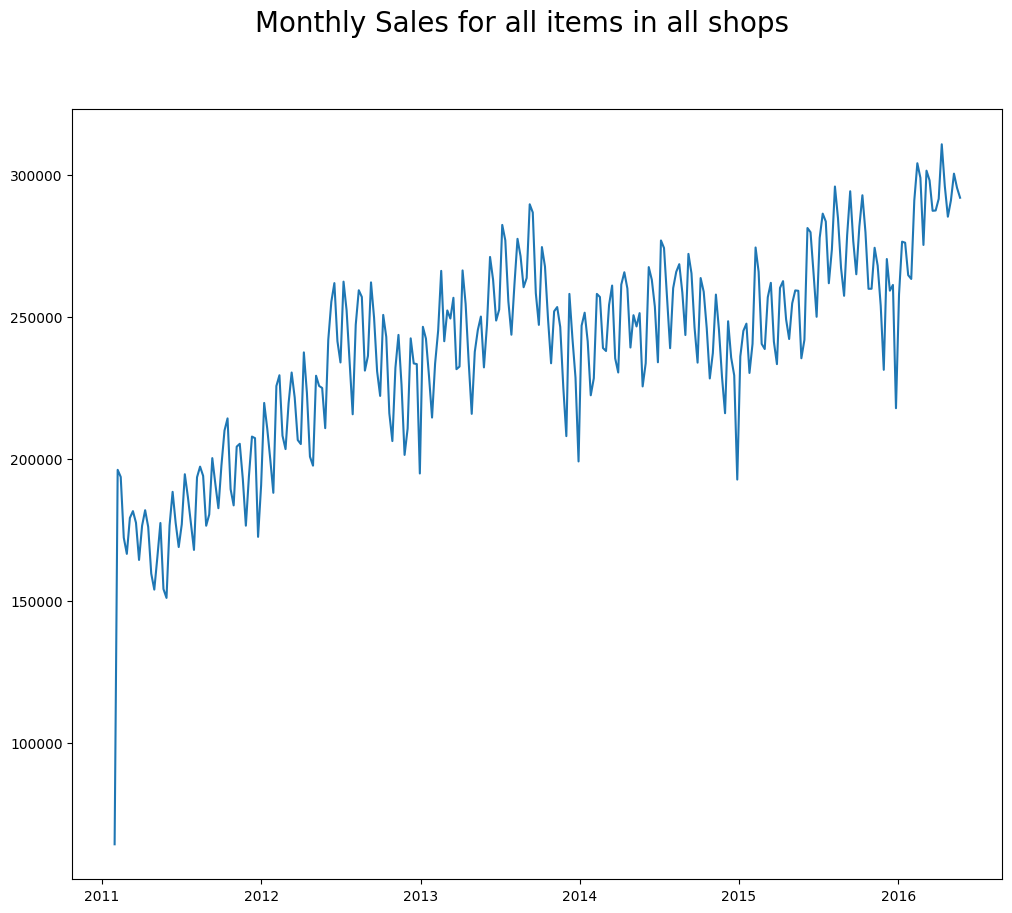

In [ ]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

In [ ]:
df_con_predicciones.reset_index(inplace=True)

In [ ]:
df_con_predicciones['revenue'] = df_con_predicciones['n_sales']*df_con_predicciones['sell_price']

In [ ]:
df_con_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406720 entries, 0 to 8406719
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   date        datetime64[ns]
 2   item        int64         
 3   category    int64         
 4   store_code  int64         
 5   region      int64         
 6   department  int64         
 7   n_sales     float64       
 8   sell_price  float64       
 9   revenue     float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 641.4+ MB


#### Note that this time series process can be repeated from the step of creating the 4 weeks into the future, hence the name multi-step. Although actually training the model with data that has already been generated with the model, rather than with real data, smooths out the predictions considerably. However, for the visualisations in Power Bi, we used the data frame with the 12-week predictions. Our model focuses on predicting 4 weeks ahead, as long as we have updated our sales data.

### 4.6 Preparing dataframe in format for viewing in Power BI.

Here are the 4-week predictions, for our Power Bi we got one to 12 by repeating our model 3 times.

In [ ]:
df_con_predicciones['id_2'] = df_con_predicciones['id'].str.replace(r'_(?=&_)|(?<=&)_', '', regex=True)

In [ ]:
df_con_predicciones.head()

,id,date,item,category,store_code,region,department,n_sales,sell_price,revenue,id_2
0,ACCESORIES_1_001_BOS_1,2011-01-30,0,0,0,0,0,0.00,12.74,0.00,ACCESORIES_1_001_BOS_1
1,ACCESORIES_1_001_BOS_2,2011-01-30,0,0,1,0,0,0.00,12.74,0.00,ACCESORIES_1_001_BOS_2
2,ACCESORIES_1_001_BOS_3,2011-01-30,0,0,2,0,0,0.00,11.46,0.00,ACCESORIES_1_001_BOS_3
3,ACCESORIES_1_001_NYC_1,2011-01-30,0,0,3,1,0,0.00,12.74,0.00,ACCESORIES_1_001_NYC_1
4,ACCESORIES_1_001_NYC_2,2011-01-30,0,0,4,1,0,0.00,10.99,0.00,ACCESORIES_1_001_NYC_2


In [ ]:
split_columns = df_con_predicciones['id_2'].str.split('_', expand = True)
split_columns

,0,1,2,3,4
0,ACCESORIES,1,001,BOS,1
1,ACCESORIES,1,001,BOS,2
2,ACCESORIES,1,001,BOS,3
3,ACCESORIES,1,001,NYC,1
4,ACCESORIES,1,001,NYC,2
...,...,...,...,...,...
8406715,SUPERMARKET,3,827,NYC,3
8406716,SUPERMARKET,3,827,NYC,4
8406717,SUPERMARKET,3,827,PHI,1
8406718,SUPERMARKET,3,827,PHI,2


In [ ]:
df_con_predicciones['item'] = split_columns[0] + '_' + split_columns[1] + '_' + split_columns[2]

df_con_predicciones['category'] = split_columns[0]

df_con_predicciones['store_code'] = split_columns[3] + '_' + split_columns[4]

df_con_predicciones['department'] = split_columns[0] + '_' + split_columns[1]

In [ ]:
df_con_predicciones['region'] = df_con_predicciones['region'].astype(object)

df_con_predicciones['region'] = np.where(df_con_predicciones['region'] == 0, 'Boston', df_con_predicciones['region'])

df_con_predicciones['region'] = np.where(df_con_predicciones['region'] == 1, 'New York', df_con_predicciones['region'])

df_con_predicciones['region'] = np.where(df_con_predicciones['region'] == 2, 'Philadelphia', df_con_predicciones['region'])

In [ ]:
df_con_predicciones['region'].unique()

array(['Boston', 'New York', 'Philadelphia'], dtype=object)

In [ ]:
df_con_predicciones.head()

,id,date,item,category,store_code,region,department,n_sales,sell_price,revenue,id_2
0,ACCESORIES_1_001_BOS_1,2011-01-30,ACCESORIES_1_001,ACCESORIES,BOS_1,Boston,ACCESORIES_1,0.00,12.74,0.00,ACCESORIES_1_001_BOS_1
1,ACCESORIES_1_001_BOS_2,2011-01-30,ACCESORIES_1_001,ACCESORIES,BOS_2,Boston,ACCESORIES_1,0.00,12.74,0.00,ACCESORIES_1_001_BOS_2
2,ACCESORIES_1_001_BOS_3,2011-01-30,ACCESORIES_1_001,ACCESORIES,BOS_3,Boston,ACCESORIES_1,0.00,11.46,0.00,ACCESORIES_1_001_BOS_3
3,ACCESORIES_1_001_NYC_1,2011-01-30,ACCESORIES_1_001,ACCESORIES,NYC_1,New York,ACCESORIES_1,0.00,12.74,0.00,ACCESORIES_1_001_NYC_1
4,ACCESORIES_1_001_NYC_2,2011-01-30,ACCESORIES_1_001,ACCESORIES,NYC_2,New York,ACCESORIES_1,0.00,10.99,0.00,ACCESORIES_1_001_NYC_2


In [ ]:
def redondeo_coma(df, lista):
  for i in lista:
    df[i] = df[i].round(2)
    df[i] = df[i].apply(lambda x: f'{x:.2f}'.replace('.', ','))

In [ ]:
lista_float = ['n_sales', 'revenue', 'sell_price']

In [ ]:
redondeo_coma(df_con_predicciones, lista_float)

In [ ]:
df_con_predicciones.drop('id_2', axis=1, inplace=True)

In [ ]:
df_con_predicciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406720 entries, 0 to 8406719
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   id          object        
 1   date        datetime64[ns]
 2   item        object        
 3   category    object        
 4   store_code  object        
 5   region      object        
 6   department  object        
 7   n_sales     object        
 8   sell_price  object        
 9   revenue     object        
dtypes: datetime64[ns](1), object(9)
memory usage: 641.4+ MB


#### We export our dataframe to work with it.

In [ ]:
df_con_predicciones.to_csv('df_con_predicciones.csv', sep = ';', index=False)

In [ ]:
df_con_predicciones = pd.read_csv('df_con_predicciones.csv', sep = ';')